In [1]:
!nvidia-smi

Sun Jan 17 19:15:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Các Thư Viện Cần Thiết

In [2]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from imutils import build_montages
import numpy as np
import argparse
import cv2
# Imports
import pandas as pd
import pickle
from __future__ import division
import os
import glob
from PIL import Image
from random import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from numpy import asarray
from sklearn.utils import  shuffle
from tqdm.notebook import  tqdm as progress_bar
from matplotlib import image
import glob
import os

In [7]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from keras.utils import np_utils
from tensorflow.keras import backend as K
# K.set_image_dim_ordering('th')
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import os
from zipfile import ZipFile
from io import BytesIO, StringIO
from PIL import Image 



2.4.0


# Hàm Load Data 




In [4]:
%cd /content/drive/My Drive/Final Project/Khang/dataset_char

/content/drive/My Drive/Final Project/Khang/dataset_char


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def load_data():
  list_zip = os.listdir("/content/drive/My Drive/Final Project/Khang/dataset_char")

  data = []
  label = []
  for file_zip in list_zip :
    zf = ZipFile(file_zip, "r")
    print("[LOADING] DATA {}".format(file_zip.split(".")[0]))
    for entry in progress_bar(zf.namelist()):
      if "jpg" in entry :
        image = zf.read(entry)
        dataEnc =  BytesIO(image)
        img = Image.open(dataEnc)

        np_img = np.array(img)
        np_img = cv2.resize(np_img, (28,28))
        #print(np_img.shape)
        data.append(np_img)
        label.append(entry.split("/")[0])

  data = np.array(data)
  label = np.array(label)

  return data, label


In [9]:
data, label = load_data()
print(data.shape, label.shape)

[LOADING] DATA -



[LOADING] DATA +



[LOADING] DATA =



[LOADING] DATA 0



[LOADING] DATA 1



[LOADING] DATA 2



[LOADING] DATA 3



[LOADING] DATA 4



[LOADING] DATA 5



[LOADING] DATA 6



[LOADING] DATA 7



[LOADING] DATA 8



[LOADING] DATA 9



[LOADING] DATA a



[LOADING] DATA b



[LOADING] DATA c



[LOADING] DATA d



[LOADING] DATA x



[LOADING] DATA y



[LOADING] DATA z



(43600, 28, 28) (43600,)


# Load Data

**One hot encoding**

In [10]:
trainX = np.expand_dims(data, axis=-1)

num_classes = len(set(label))
le = preprocessing.LabelEncoder()
le.fit(label)
trainY = le.transform(label)
trainY = to_categorical(trainY, num_classes=num_classes)
trainX, trainY = shuffle(trainX, trainY, random_state=25)

**Split data**

In [11]:
x_train, x_val, y_train, y_val = train_test_split(trainX, trainY, test_size = 0.2, random_state=42)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(34880, 28, 28, 1) (8720, 28, 28, 1) (34880, 20) (8720, 20)


# Data Generator

In [12]:
datagen = ImageDataGenerator(
    width_shift_range = 2,
    height_shift_range = 2,
    zoom_range=[0.5,1.1],
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='constant',
)

datagen.fit(x_train)
dstrain = datagen.flow(x_train, y_train, batch_size=32)

datagen.fit(x_val)
dsval = datagen.flow(x_val, y_val, batch_size=32)

# Built Model

In [13]:
class vgg16():
    '''
    1. ZeroPadding2D (2, 2)
    2. (3X3 Conv2D 64) X 2 + maxpool
    3. (3X3 Conv2D 128) X 2 + maxpool
    4. (3X3 Conv2D 256) X 3 + maxpool
    5. (3X3 Conv2D 512) X 3 + maxpool
    6. (3X3 Conv2D 512) X 3 + maxpool
    7. (FC 256 + Dropout(0.5)) X 2
    8. FC 10 + Softmax
    '_build()' is only modified when the model changes.
    HowToUse:
        model = VGG16()
        * all funtionalities are written in BaseModel.py
    '''
    def __init__(self, dstrain, dsval, epochs, batch_size):
        self.model = self._build()
        self.model.summary()
        self.dstrain = dstrain
        self.dsval = dsval
        self.epochs = epochs
        self.batch_size = batch_size

    def _build(self):
        '''
        Builds VGG16. Details written in the paper below.
        - Very Deep Convolutional Networks for Large-Scale Image Recognition
          (https://arxiv.org/abs/1409.1556)
        Returns:
            VGG16 model
        '''
        x = Input(shape = (28, 28, 1))
        y = ZeroPadding2D(padding = (2, 2))(x) # matching the image size of CIFAR-10

        y = self._multi_conv_pool(y, 64, 2) # 32x32
        y = self._multi_conv_pool(y, 128, 2) # 16x16
        y = self._multi_conv_pool(y, 256, 3) # 8x8
        y = self._multi_conv_pool(y, 512, 3) # 4x4
        y = self._multi_conv_pool(y, 512, 3) # 2x2
        y = Flatten()(y)
        y = Dense(units = 256, activation='relu')(y) # original paper suggests 4096 FC
        y = Dropout(0.5)(y)
        y = Dense(units = 256, activation='relu')(y)
        y = Dropout(0.5)(y)
        y = Dense(units =20)(y)
        y = Activation('softmax')(y)

        return Model(x, y)

    def _multi_conv_pool(self, x, output_channel, n):
        '''
        Builds (Conv2D - BN - Relu) X n - MaxPooling2D
        The training is regularized by global weight decay (5e-4) in the original paper,
        but BN is used here instead of weight decay
        Returns:
            multi conv + max pooling block
        '''
        y = x
        for _ in range(n):
            y = Conv2D(output_channel, (3, 3), padding = 'same')(y)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
        y = MaxPooling2D(strides = (2, 2))(y)
        return y

    def train(self):
      reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                                    mode = 'min', patience = 5, verbose = 1)
      checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Final Project/Khang/weights/model_ocr_test.h5',
                        monitor='val_acc',
                        mode = 'max',
                        verbose=1,
                        save_best_only=True)
      callbacks = [checkpoint, reduce_lr]

      optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-04)

      self.model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics=['acc'])

      #self.model.load_weights('/content/drive/My Drive/Final Project/Khang/equation_cropped/model6.h5')

      history = self.model.fit(self.dstrain,
                     validation_data = self.dsval,
                     epochs = self.epochs,
                     batch_size = self.batch_size,
                     callbacks = callbacks,
                     verbose = 1)
      
      plt.plot(history.history['acc'])
      plt.plot(history.history['val_acc'])
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper left')
      plt.show()
      # "Loss"
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper left')
      plt.show()
      
    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256   

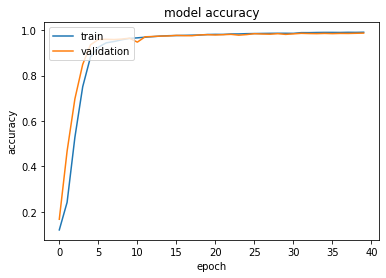

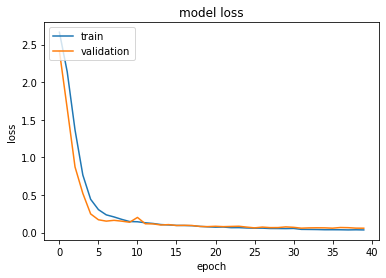

In [14]:
model = vgg16(dstrain, dsval, 40, 128 )

model.train()